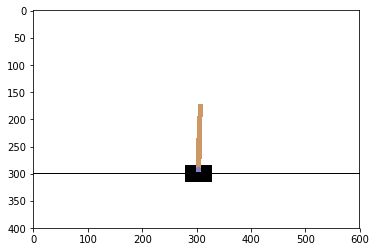

In [1]:
import gym
import numpy as np
import seaborn as sns
from gym import logger
import matplotlib.pyplot as plt
%matplotlib inline
logger.set_level(logger.ERROR)

env = gym.make('CartPole-v1')
env.reset()
plt.imshow(env.render(mode='rgb_array'))
env.close()

Mean random agent reward:  22.287


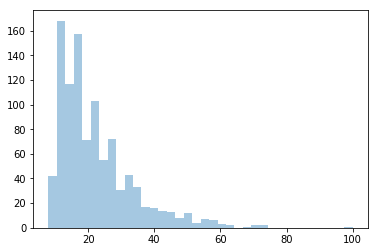

In [2]:
from src.rl.RandomAgent import RandomAgent
from src.rl.util import run_episode

agent = RandomAgent()
dist = [run_episode(env, agent, max_length=100) for _ in range(1000)]
sns.distplot(dist, kde=False)
print("Mean random agent reward: ", np.mean(dist))

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 224/1000 [00:00<00:00, 2223.65it/s]

 33%|███▎      | 333/1000 [00:00<00:00, 1655.27it/s]

 53%|█████▎    | 533/1000 [00:00<00:00, 1769.10it/s]

 76%|███████▌  | 756/1000 [00:00<00:00, 1882.32it/s]

 96%|█████████▌| 957/1000 [00:00<00:00, 1904.31it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1899.47it/s]


/home/ralars/.local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Trained for  1000  episodes. Last episode achieved a reward of  34.0 . Last episode run: 


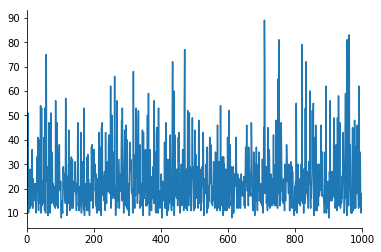

In [3]:
from src.rl.TabularQAgent import TabularQAgent
from tqdm import tqdm

agent = TabularQAgent(0.1, 0.5, 0.99)


def run_experiment(env, agent, epsilon_decay, n_episodes) -> list:
    rewards = []
    for i in tqdm(range(n_episodes)):
        sum_r = run_episode(env, agent, learn=True)
        rewards.append(sum_r)
        agent.epsilon *= epsilon_decay
    agent.epsilon = 0
    sum_r = run_episode(env, agent)
    print('Trained for ', n_episodes, ' episodes. Last episode achieved a reward of ', sum_r, '. Last episode run: ')     
    #env.render(mode='path', ss=ss)
    return rewards


#run_episode(env, agent, learn=True)
rewards = run_experiment(env, agent, 0.99, 1000)
sns.tsplot(rewards)
sns.despine()

Compare random histogram to histogram of training - does it look different? How come?

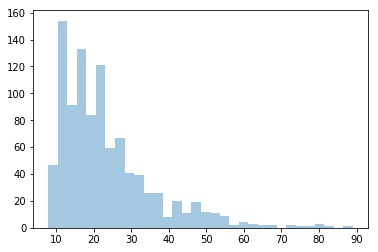

In [4]:
sns.distplot(rewards, kde=False)

In [5]:
from src.rl.NeuralQAgent import NeuralQAgent

agent = NeuralQAgent(4, env.action_space.n, 0.001, 1.0, 1.0)
rewards = run_experiment(env, agent, 0.995, 2000)
sns.tsplot(rewards)
sns.despine()

/home/ralars/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 2/2000 [00:00<06:11,  5.38it/s]

  0%|          | 5/2000 [00:00<03:14, 10.27it/s]

  0%|          | 9/2000 [00:00<02:10, 15.20it/s]

  1%|          | 14/2000 [00:00<01:42, 19.36it/s]

  1%|          | 17/2000 [00:00<01:45, 18.86it/s]

  1%|          | 21/2000 [00:01<01:36, 20.61it/s]

  1%|▏         | 25/2000 [00:01<01:30, 21.89it/s]

  1%|▏         | 29/2000 [00:01<01:24, 23.33it/s]

  2%|▏         | 33/2000 [00:01<01:24, 23.38it/s]

  2%|▏         | 37/2000 [00:01<01:21, 24.21it/s]

  2%|▏         | 41/2000 [00:01<01:18, 24.88it/s]

  2%|▏         | 45/2000 [00:01<01:18, 25.06it/s]

  2%|▏         | 49/2000 [00:01<01:17, 25.20it/s]

  3%|▎         | 53/2000 [00:02<01:15, 25.64it/s]

  3%|▎         | 57/2000 [00:02<01:16, 25.51it/s]

  3%|▎         | 61/2000 [00:02<01:16, 25.51it/s]

  3%|▎         | 64/2000 [00:02<01:15, 25.60it/s]

  3%|▎         | 67/2000 [00:02<01:15, 25.47it/s]

  4%|▎         | 70/2000 [00:02<01:15, 25.60it/s]

  4%|▍         | 75/2000 [00:02<01:13, 26.05it/s]

  4%|▍         | 80/2000 [00:02<01:11, 26.78it/s]

  4%|▍         | 84/2000 [00:03<01:10, 27.16it/s]

  4%|▍         | 89/2000 [00:03<01:08, 27.70it/s]

  5%|▍         | 93/2000 [00:03<01:08, 27.93it/s]

  5%|▍         | 98/2000 [00:03<01:06, 28.55it/s]

  5%|▌         | 103/2000 [00:03<01:05, 28.92it/s]

  5%|▌         | 108/2000 [00:03<01:04, 29.18it/s]

  6%|▌         | 114/2000 [00:03<01:03, 29.83it/s]

  6%|▌         | 119/2000 [00:03<01:02, 30.32it/s]

  6%|▌         | 124/2000 [00:04<01:01, 30.66it/s]

  6%|▋         | 129/2000 [00:04<01:00, 31.01it/s]

  7%|▋         | 134/2000 [00:04<00:59, 31.25it/s]

  7%|▋         | 139/2000 [00:04<00:58, 31.59it/s]

  7%|▋         | 144/2000 [00:04<00:58, 31.94it/s]

  7%|▋         | 149/2000 [00:04<00:57, 32.14it/s]

  8%|▊         | 155/2000 [00:04<00:56, 32.61it/s]

  8%|▊         | 160/2000 [00:04<00:55, 32.93it/s]

  8%|▊         | 166/2000 [00:04<00:55, 33.26it/s]

  9%|▊         | 171/2000 [00:05<00:54, 33.35it/s]

  9%|▉         | 177/2000 [00:05<00:53, 33.76it/s]

  9%|▉         | 182/2000 [00:05<00:53, 33.90it/s]

  9%|▉         | 187/2000 [00:05<00:53, 33.83it/s]

 10%|▉         | 192/2000 [00:05<00:54, 33.27it/s]

 10%|▉         | 196/2000 [00:06<00:55, 32.39it/s]

 10%|▉         | 199/2000 [00:06<00:56, 32.03it/s]

 10%|█         | 202/2000 [00:06<00:56, 31.81it/s]

 10%|█         | 205/2000 [00:06<00:57, 31.45it/s]

 10%|█         | 208/2000 [00:06<00:57, 31.12it/s]

 11%|█         | 211/2000 [00:06<00:58, 30.75it/s]

 11%|█         | 213/2000 [00:07<00:58, 30.40it/s]

 11%|█         | 215/2000 [00:07<00:59, 30.12it/s]

 11%|█         | 218/2000 [00:07<00:59, 30.03it/s]

 11%|█         | 221/2000 [00:07<00:59, 29.91it/s]

 11%|█         | 224/2000 [00:07<01:00, 29.51it/s]

 11%|█▏        | 226/2000 [00:07<01:00, 29.32it/s]

 11%|█▏        | 228/2000 [00:07<01:01, 29.00it/s]

 12%|█▏        | 230/2000 [00:07<01:01, 28.82it/s]

 12%|█▏        | 232/2000 [00:08<01:01, 28.62it/s]

 12%|█▏        | 234/2000 [00:08<01:02, 28.32it/s]

 12%|█▏        | 237/2000 [00:08<01:02, 28.33it/s]

 12%|█▏        | 239/2000 [00:08<01:02, 28.09it/s]

 12%|█▏        | 241/2000 [00:08<01:03, 27.82it/s]

 12%|█▏        | 243/2000 [00:08<01:03, 27.64it/s]

 12%|█▏        | 245/2000 [00:08<01:03, 27.44it/s]

 12%|█▏        | 247/2000 [00:09<01:04, 27.31it/s]

 12%|█▏        | 249/2000 [00:09<01:04, 27.18it/s]

 13%|█▎        | 251/2000 [00:09<01:04, 27.06it/s]

 13%|█▎        | 253/2000 [00:09<01:05, 26.85it/s]

 13%|█▎        | 255/2000 [00:09<01:05, 26.72it/s]

 13%|█▎        | 257/2000 [00:09<01:05, 26.54it/s]

 13%|█▎        | 259/2000 [00:09<01:05, 26.43it/s]

 13%|█▎        | 261/2000 [00:09<01:06, 26.34it/s]

 13%|█▎        | 263/2000 [00:10<01:06, 26.11it/s]

 13%|█▎        | 265/2000 [00:10<01:07, 25.89it/s]

 13%|█▎        | 267/2000 [00:10<01:07, 25.82it/s]

 13%|█▎        | 269/2000 [00:10<01:07, 25.64it/s]

 14%|█▎        | 271/2000 [00:10<01:08, 25.24it/s]

 14%|█▎        | 273/2000 [00:10<01:08, 25.19it/s]

 14%|█▍        | 276/2000 [00:10<01:08, 25.11it/s]

 14%|█▍        | 278/2000 [00:11<01:08, 25.04it/s]

 14%|█▍        | 280/2000 [00:11<01:09, 24.84it/s]

 14%|█▍        | 282/2000 [00:11<01:09, 24.62it/s]

 14%|█▍        | 284/2000 [00:11<01:10, 24.51it/s]

 14%|█▍        | 286/2000 [00:11<01:10, 24.42it/s]

 14%|█▍        | 288/2000 [00:11<01:10, 24.30it/s]

 14%|█▍        | 290/2000 [00:12<01:11, 23.89it/s]

 15%|█▍        | 292/2000 [00:12<01:12, 23.64it/s]

 15%|█▍        | 294/2000 [00:12<01:13, 23.16it/s]

 15%|█▍        | 295/2000 [00:12<01:14, 23.03it/s]

 15%|█▍        | 297/2000 [00:12<01:14, 22.87it/s]

 15%|█▍        | 298/2000 [00:13<01:15, 22.54it/s]

 15%|█▍        | 299/2000 [00:13<01:15, 22.41it/s]

 15%|█▌        | 301/2000 [00:13<01:16, 22.25it/s]

 15%|█▌        | 303/2000 [00:13<01:17, 21.99it/s]

 15%|█▌        | 304/2000 [00:14<01:18, 21.69it/s]

 15%|█▌        | 305/2000 [00:14<01:18, 21.51it/s]

 15%|█▌        | 307/2000 [00:14<01:19, 21.40it/s]

 15%|█▌        | 308/2000 [00:14<01:19, 21.31it/s]

 15%|█▌        | 309/2000 [00:14<01:19, 21.19it/s]

 16%|█▌        | 310/2000 [00:14<01:21, 20.85it/s]

 16%|█▌        | 311/2000 [00:15<01:21, 20.70it/s]

 16%|█▌        | 312/2000 [00:15<01:22, 20.53it/s]

 16%|█▌        | 313/2000 [00:15<01:22, 20.44it/s]

 16%|█▌        | 314/2000 [00:15<01:22, 20.36it/s]

 16%|█▌        | 316/2000 [00:15<01:23, 20.17it/s]

 16%|█▌        | 317/2000 [00:15<01:24, 20.01it/s]

 16%|█▌        | 320/2000 [00:16<01:24, 19.87it/s]

 16%|█▌        | 321/2000 [00:16<01:24, 19.78it/s]

 16%|█▌        | 322/2000 [00:16<01:25, 19.61it/s]

 16%|█▌        | 324/2000 [00:16<01:26, 19.43it/s]

 16%|█▋        | 325/2000 [00:16<01:26, 19.33it/s]

 16%|█▋        | 326/2000 [00:16<01:26, 19.26it/s]

 16%|█▋        | 327/2000 [00:17<01:27, 19.17it/s]

 16%|█▋        | 329/2000 [00:17<01:28, 18.87it/s]

 16%|█▋        | 330/2000 [00:17<01:28, 18.79it/s]

 17%|█▋        | 331/2000 [00:17<01:29, 18.69it/s]

 17%|█▋        | 332/2000 [00:17<01:29, 18.62it/s]

 17%|█▋        | 333/2000 [00:18<01:30, 18.50it/s]

 17%|█▋        | 334/2000 [00:18<01:30, 18.40it/s]

 17%|█▋        | 335/2000 [00:18<01:31, 18.20it/s]

 17%|█▋        | 336/2000 [00:19<01:35, 17.47it/s]

 17%|█▋        | 337/2000 [00:19<01:35, 17.34it/s]

 17%|█▋        | 338/2000 [00:19<01:36, 17.16it/s]

 17%|█▋        | 339/2000 [00:19<01:37, 17.01it/s]

 17%|█▋        | 340/2000 [00:20<01:37, 16.94it/s]

 17%|█▋        | 341/2000 [00:20<01:38, 16.84it/s]

 17%|█▋        | 342/2000 [00:20<01:39, 16.69it/s]

 17%|█▋        | 343/2000 [00:20<01:39, 16.62it/s]

 17%|█▋        | 344/2000 [00:20<01:40, 16.56it/s]

 17%|█▋        | 345/2000 [00:21<01:40, 16.40it/s]

 17%|█▋        | 346/2000 [00:21<01:42, 16.19it/s]

 17%|█▋        | 347/2000 [00:21<01:43, 16.03it/s]

 17%|█▋        | 348/2000 [00:21<01:43, 15.97it/s]

 17%|█▋        | 349/2000 [00:22<01:44, 15.86it/s]

 18%|█▊        | 350/2000 [00:22<01:44, 15.72it/s]

 18%|█▊        | 351/2000 [00:22<01:45, 15.60it/s]

 18%|█▊        | 352/2000 [00:22<01:46, 15.51it/s]

 18%|█▊        | 353/2000 [00:22<01:46, 15.42it/s]

 18%|█▊        | 354/2000 [00:23<01:47, 15.34it/s]

 18%|█▊        | 355/2000 [00:23<01:47, 15.28it/s]

 18%|█▊        | 356/2000 [00:23<01:48, 15.10it/s]

 18%|█▊        | 357/2000 [00:23<01:49, 14.97it/s]

 18%|█▊        | 358/2000 [00:24<01:50, 14.91it/s]

 18%|█▊        | 359/2000 [00:24<01:50, 14.80it/s]

 18%|█▊        | 360/2000 [00:24<01:51, 14.65it/s]

 18%|█▊        | 361/2000 [00:24<01:52, 14.51it/s]

 18%|█▊        | 362/2000 [00:25<01:54, 14.34it/s]

 18%|█▊        | 363/2000 [00:25<01:55, 14.21it/s]

 18%|█▊        | 364/2000 [00:26<01:57, 13.97it/s]

 18%|█▊        | 365/2000 [00:26<01:58, 13.80it/s]

 18%|█▊        | 366/2000 [00:26<01:59, 13.63it/s]

 18%|█▊        | 367/2000 [00:27<02:02, 13.32it/s]

 18%|█▊        | 368/2000 [00:28<02:06, 12.95it/s]

 18%|█▊        | 369/2000 [00:28<02:08, 12.73it/s]

 18%|█▊        | 370/2000 [00:29<02:10, 12.49it/s]

 19%|█▊        | 371/2000 [00:30<02:14, 12.15it/s]

 19%|█▊        | 372/2000 [00:30<02:15, 12.02it/s]

 19%|█▊        | 373/2000 [00:31<02:17, 11.82it/s]

 19%|█▊        | 374/2000 [00:31<02:19, 11.70it/s]

 19%|█▉        | 375/2000 [00:32<02:20, 11.58it/s]

 19%|█▉        | 376/2000 [00:32<02:21, 11.49it/s]

 19%|█▉        | 377/2000 [00:33<02:22, 11.41it/s]

 19%|█▉        | 378/2000 [00:33<02:23, 11.31it/s]

 19%|█▉        | 379/2000 [00:33<02:24, 11.20it/s]

 19%|█▉        | 380/2000 [00:34<02:25, 11.13it/s]

 19%|█▉        | 381/2000 [00:34<02:26, 11.05it/s]

 19%|█▉        | 382/2000 [00:34<02:27, 10.98it/s]

 19%|█▉        | 383/2000 [00:35<02:28, 10.91it/s]

 19%|█▉        | 384/2000 [00:35<02:29, 10.85it/s]

 19%|█▉        | 385/2000 [00:35<02:29, 10.79it/s]

 19%|█▉        | 386/2000 [00:36<02:30, 10.71it/s]

 19%|█▉        | 387/2000 [00:36<02:31, 10.64it/s]

 19%|█▉        | 388/2000 [00:36<02:32, 10.58it/s]

 19%|█▉        | 389/2000 [00:37<02:33, 10.49it/s]

 20%|█▉        | 390/2000 [00:37<02:34, 10.40it/s]

 20%|█▉        | 391/2000 [00:37<02:35, 10.34it/s]

 20%|█▉        | 392/2000 [00:38<02:36, 10.28it/s]

 20%|█▉        | 393/2000 [00:38<02:37, 10.21it/s]

 20%|█▉        | 394/2000 [00:38<02:38, 10.14it/s]

 20%|█▉        | 395/2000 [00:39<02:39, 10.08it/s]

 20%|█▉        | 396/2000 [00:39<02:40, 10.02it/s]

 20%|█▉        | 397/2000 [00:39<02:41,  9.96it/s]

 20%|█▉        | 398/2000 [00:40<02:41,  9.90it/s]

 20%|█▉        | 399/2000 [00:40<02:42,  9.84it/s]

 20%|██        | 400/2000 [00:41<02:44,  9.74it/s]

 20%|██        | 401/2000 [00:41<02:44,  9.69it/s]

 20%|██        | 402/2000 [00:41<02:45,  9.63it/s]

 20%|██        | 403/2000 [00:42<02:46,  9.58it/s]

 20%|██        | 404/2000 [00:42<02:47,  9.53it/s]

 20%|██        | 405/2000 [00:42<02:48,  9.48it/s]

 20%|██        | 406/2000 [00:43<02:49,  9.43it/s]

 20%|██        | 407/2000 [00:43<02:49,  9.37it/s]

 20%|██        | 408/2000 [00:43<02:50,  9.32it/s]

 20%|██        | 409/2000 [00:44<02:51,  9.28it/s]

 20%|██        | 410/2000 [00:44<02:52,  9.22it/s]

 21%|██        | 411/2000 [00:44<02:53,  9.17it/s]

 21%|██        | 412/2000 [00:45<02:54,  9.11it/s]

 21%|██        | 413/2000 [00:45<02:55,  9.05it/s]

 21%|██        | 414/2000 [00:45<02:56,  9.00it/s]

 21%|██        | 415/2000 [00:46<02:57,  8.95it/s]

 21%|██        | 416/2000 [00:46<02:58,  8.90it/s]

 21%|██        | 417/2000 [00:47<02:58,  8.85it/s]

 21%|██        | 418/2000 [00:47<02:59,  8.80it/s]

 21%|██        | 419/2000 [00:47<03:00,  8.75it/s]

 21%|██        | 420/2000 [00:48<03:01,  8.70it/s]

 21%|██        | 421/2000 [00:48<03:02,  8.65it/s]

 21%|██        | 422/2000 [00:49<03:03,  8.59it/s]

 21%|██        | 423/2000 [00:49<03:04,  8.54it/s]

 21%|██        | 424/2000 [00:50<03:06,  8.46it/s]

 21%|██▏       | 425/2000 [00:50<03:07,  8.40it/s]

 21%|██▏       | 426/2000 [00:51<03:08,  8.35it/s]

 21%|██▏       | 427/2000 [00:51<03:09,  8.31it/s]

 21%|██▏       | 428/2000 [00:51<03:10,  8.26it/s]

 21%|██▏       | 429/2000 [00:52<03:11,  8.22it/s]

 22%|██▏       | 430/2000 [00:52<03:12,  8.17it/s]

 22%|██▏       | 431/2000 [00:52<03:12,  8.13it/s]

 22%|██▏       | 432/2000 [00:53<03:13,  8.09it/s]

 22%|██▏       | 433/2000 [00:53<03:14,  8.05it/s]

 22%|██▏       | 434/2000 [00:54<03:15,  8.01it/s]

 22%|██▏       | 435/2000 [00:54<03:16,  7.95it/s]

 22%|██▏       | 436/2000 [00:55<03:18,  7.88it/s]

 22%|██▏       | 437/2000 [00:55<03:19,  7.83it/s]

 22%|██▏       | 438/2000 [00:56<03:20,  7.79it/s]

 22%|██▏       | 439/2000 [00:56<03:21,  7.74it/s]

 22%|██▏       | 440/2000 [00:57<03:22,  7.69it/s]

 22%|██▏       | 441/2000 [00:57<03:23,  7.65it/s]

 22%|██▏       | 442/2000 [00:58<03:24,  7.60it/s]

 22%|██▏       | 443/2000 [00:58<03:25,  7.56it/s]

 22%|██▏       | 444/2000 [00:58<03:26,  7.54it/s]

 22%|██▏       | 445/2000 [00:59<03:26,  7.53it/s]

 22%|██▏       | 446/2000 [00:59<03:26,  7.53it/s]

 22%|██▏       | 447/2000 [00:59<03:26,  7.52it/s]

 22%|██▏       | 449/2000 [00:59<03:25,  7.54it/s]

 23%|██▎       | 451/2000 [00:59<03:25,  7.54it/s]

 23%|██▎       | 453/2000 [00:59<03:24,  7.56it/s]

 23%|██▎       | 456/2000 [01:00<03:23,  7.60it/s]

 23%|██▎       | 458/2000 [01:00<03:23,  7.59it/s]

 23%|██▎       | 463/2000 [01:00<03:20,  7.66it/s]

 23%|██▎       | 466/2000 [01:00<03:19,  7.70it/s]

 24%|██▎       | 471/2000 [01:00<03:16,  7.76it/s]

 24%|██▍       | 476/2000 [01:00<03:14,  7.83it/s]

 24%|██▍       | 480/2000 [01:00<03:12,  7.88it/s]

 24%|██▍       | 484/2000 [01:01<03:13,  7.83it/s]

 24%|██▍       | 487/2000 [01:02<03:15,  7.75it/s]

 24%|██▍       | 489/2000 [01:03<03:16,  7.69it/s]

 25%|██▍       | 491/2000 [01:04<03:17,  7.63it/s]

 25%|██▍       | 492/2000 [01:04<03:18,  7.61it/s]

 25%|██▍       | 493/2000 [01:05<03:18,  7.58it/s]

 25%|██▍       | 494/2000 [01:05<03:19,  7.55it/s]

 25%|██▍       | 495/2000 [01:05<03:20,  7.52it/s]

 25%|██▍       | 496/2000 [01:06<03:20,  7.50it/s]

 25%|██▍       | 497/2000 [01:06<03:21,  7.47it/s]

 25%|██▍       | 498/2000 [01:06<03:21,  7.44it/s]

 25%|██▍       | 499/2000 [01:07<03:22,  7.41it/s]

 25%|██▌       | 500/2000 [01:07<03:23,  7.38it/s]

 25%|██▌       | 501/2000 [01:08<03:24,  7.34it/s]

 25%|██▌       | 502/2000 [01:08<03:24,  7.31it/s]

 25%|██▌       | 503/2000 [01:09<03:25,  7.27it/s]

 25%|██▌       | 504/2000 [01:09<03:26,  7.24it/s]

 25%|██▌       | 505/2000 [01:10<03:27,  7.19it/s]

 25%|██▌       | 506/2000 [01:10<03:28,  7.15it/s]

 25%|██▌       | 507/2000 [01:11<03:29,  7.12it/s]

 25%|██▌       | 508/2000 [01:11<03:30,  7.08it/s]

 25%|██▌       | 509/2000 [01:12<03:32,  7.03it/s]

 26%|██▌       | 510/2000 [01:12<03:32,  7.00it/s]

 26%|██▌       | 511/2000 [01:13<03:33,  6.96it/s]

 26%|██▌       | 512/2000 [01:13<03:34,  6.93it/s]

 26%|██▌       | 513/2000 [01:14<03:35,  6.89it/s]

 26%|██▌       | 514/2000 [01:14<03:36,  6.85it/s]

 26%|██▌       | 515/2000 [01:15<03:37,  6.82it/s]

 26%|██▌       | 516/2000 [01:16<03:38,  6.78it/s]

 26%|██▌       | 517/2000 [01:16<03:39,  6.74it/s]

 26%|██▌       | 518/2000 [01:17<03:40,  6.71it/s]

 26%|██▌       | 519/2000 [01:17<03:41,  6.68it/s]

 26%|██▌       | 520/2000 [01:18<03:42,  6.64it/s]

 26%|██▌       | 521/2000 [01:18<03:44,  6.60it/s]

 26%|██▌       | 522/2000 [01:19<03:45,  6.56it/s]

 26%|██▌       | 523/2000 [01:20<03:46,  6.51it/s]

 26%|██▌       | 524/2000 [01:20<03:48,  6.47it/s]

 26%|██▋       | 525/2000 [01:21<03:49,  6.43it/s]

 26%|██▋       | 526/2000 [01:22<03:50,  6.40it/s]

 26%|██▋       | 527/2000 [01:22<03:51,  6.36it/s]

 26%|██▋       | 528/2000 [01:23<03:53,  6.31it/s]

 26%|██▋       | 529/2000 [01:24<03:54,  6.27it/s]

 26%|██▋       | 530/2000 [01:25<03:56,  6.23it/s]

 27%|██▋       | 531/2000 [01:25<03:57,  6.18it/s]

 27%|██▋       | 532/2000 [01:26<03:59,  6.12it/s]

 27%|██▋       | 533/2000 [01:27<04:01,  6.07it/s]

 27%|██▋       | 534/2000 [01:28<04:03,  6.01it/s]

 27%|██▋       | 535/2000 [01:29<04:05,  5.96it/s]

 27%|██▋       | 536/2000 [01:30<04:07,  5.90it/s]

 27%|██▋       | 537/2000 [01:31<04:10,  5.85it/s]

 27%|██▋       | 538/2000 [01:32<04:12,  5.80it/s]

 27%|██▋       | 539/2000 [01:33<04:14,  5.75it/s]

 27%|██▋       | 540/2000 [01:34<04:16,  5.70it/s]

 27%|██▋       | 541/2000 [01:35<04:18,  5.65it/s]

 27%|██▋       | 542/2000 [01:36<04:20,  5.60it/s]

 27%|██▋       | 543/2000 [01:37<04:22,  5.56it/s]

 27%|██▋       | 544/2000 [01:38<04:24,  5.51it/s]

 27%|██▋       | 545/2000 [01:39<04:26,  5.46it/s]